**Computer Vision Project**

**Neural Style Tranfer of an Image**

In this project, we take two images as input, one the content image and another one style image and represents content image in theme of style image. 



**cloning github repositeries containing content and style images**

In [ ]:
  !pip install torch torchvision
  !git clone https://github.com/parth1620/Project-NST.git

Cloning into 'Project-NST'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 19 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (19/19), done.


Download pre-trained vgg19 model

In [ ]:
import torch
from torchvision import models

In [ ]:
vgg = models.vgg19(pretrained=True).features
print(vgg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth



Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPo

In [ ]:
for parameters in vgg.parameters():
  parameters.requires_grad_(False)

In [ ]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

In [ ]:
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
from PIL import Image
from torchvision import transforms as tf


def process(img_path,max_size = 500):
  image = Image.open(img_path).convert('RGB')

  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)


  img_trnsfrms = tf.Compose([
                             
                             tf.Resize(size),
                             tf.ToTensor(),
                             tf.Normalize(mean = [0.485, 0.456, 0.406],
                                          std = [0.229, 0.224, 0.225])
  ])

  image = img_trnsfrms(image)
  image = image.unsqueeze(0)
  return image

In [ ]:
content_img_p = process('/content/Project-NST/content10.jpg')
style_img_p = process('/content/Project-NST/style10.jpg')

content_img_p = content_img_p.to(device)
style_img_p = style_img_p.to(device)
print(content_img_p.shape)
print(style_img_p.shape)

torch.Size([1, 3, 487, 487])
torch.Size([1, 3, 500, 765])


In [ ]:
import numpy as np
import matplotlib.pyplot as plt 

def deprocess(tensor):
  image = tensor.to('cpu').clone()
  image = image.numpy()
  image = image.squeeze(0)
  image = image.transpose(1,2,0)
  image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
  image = image.clip(0,1)

  return image

In [ ]:
content_img_d = deprocess(content_img_p)
style_img_d  = deprocess(style_img_p)

print(style_img_d.shape)
print(content_img_d.shape)

(500, 765, 3)
(487, 487, 3)


In [ ]:
def features(image,model):
  layers = {
      '0': 'conv1_1',
      '5': 'conv2_1',
      '10': 'conv3_1',
      '19': 'conv4_1',
      '21': 'conv4_2', #content feature
      '28': 'conv5_1',
  }

  x = image
  Features = {}

  for name,layer in model._modules.items():

    x = layer(x)

    if name in layers:
      Features[layers[name]] = x

  return Features

In [ ]:
content_features = features(content_img_p, vgg)
style_features = features(style_img_p,vgg)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
def gram_matrix(tensor):
  b, c, h, w = tensor.size()
  tensor = tensor.view(c,h*w)
  gram = torch.mm(tensor,tensor.t())
  return gram

In [ ]:
style_gram = {layer : gram_matrix(style_features[layer]) for layer in style_features}

In [ ]:
def cont_loss(target_conv4_2,content_conv4_2):

  loss = torch.mean((target_conv4_2-content_conv4_2)**2)

  return loss

In [ ]:
style_weights = {
    'conv1_1' : 1.0,
    'conv2_1' : 0.75,
    'conv3_1' : 0.2,
    'conv4_1' : 0.2,
    'conv5_1' : 0.2
}

In [ ]:
def style_loss(style_weights,target_features,style_grams):
  loss = 0

  for layer in style_weights:
    target_f = target_features[layer]
    target_gram = gram_matrix(target_f)
    style_gram = style_grams[layer]
    b,c,h,w = target_f.shape
    layer_loss = style_weights[layer] * torch.mean((target_gram-style_gram)**2)
    loss += layer_loss / (c*h*w)

  return loss


In [ ]:
target = content_img_p.clone().requires_grad_(True).to(device)
target_f = features(target,vgg)
print(target_f['conv4_2'])
print('content loss:', cont_loss(target_f['conv4_2'],content_features['conv4_2']))
print('style loss: ', style_loss(style_weights,target_f,style_gram))

In [ ]:
from torch import optim

optimizer = optim.Adam([target],lr = 0.003)

alpha = 1
beta = 1e5

epochs = 3000
show_every = 500

In [ ]:
def total_loss(c_loss,s_loss,alpha,beta):
  loss = alpha*c_loss + beta*s_loss
  return loss

In [ ]:
results = []

for i in range(epochs):
  target_f = features(target,vgg)

  c_loss = cont_loss(target_f['conv4_2'],content_features['conv4_2'])
  s_loss = style_loss(style_weights,target_f,style_gram)
  t_loss = total_loss(c_loss,s_loss,alpha,beta)

  optimizer.zero_grad()
  t_loss.backward()
  optimizer.step()

  if i % show_every == 0:
    print("Total Loss at Epoch {} : {}".format(i,t_loss))
    results.append(deprocess(target.detach()))


print("Total Loss at Epoch {} : {}".format(i,t_loss))
results.append(deprocess(target.detach()))

Total Loss at Epoch 0 : 134307152.0
Total Loss at Epoch 500 : 70788240.0
Total Loss at Epoch 1000 : 35919936.0
Total Loss at Epoch 1500 : 17365564.0
Total Loss at Epoch 2000 : 9932725.0
Total Loss at Epoch 2500 : 6311957.5
Total Loss at Epoch 2999 : 4259633.0


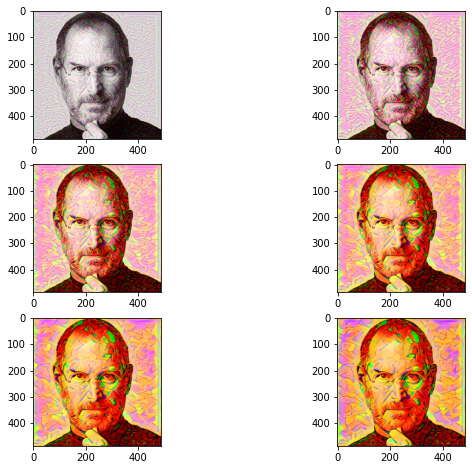

In [ ]:
plt.figure(figsize = (10,8))

for i in range(6):

  plt.subplot(3,2,i+1)
  plt.imshow(results[i])

plt.show()